[iter 0] avg CV loss: 1.881115
lengthscale: tensor([0.2861, 0.3495, 0.3495, 0.3495, 0.2861, 0.3495, 0.3495, 0.3495, 0.3495,
        0.3495], grad_fn=<ExpBackward0>)
[iter 10] avg CV loss: 1.244512
lengthscale: tensor([0.1591, 0.6485, 0.7151, 0.8319, 0.4066, 0.7998, 0.7992, 0.8282, 0.8653,
        0.8412], grad_fn=<ExpBackward0>)
[iter 20] avg CV loss: 1.250070
lengthscale: tensor([0.1272, 0.4923, 0.6362, 1.2764, 0.6454, 1.1463, 1.1277, 1.2932, 1.4014,
        1.2719], grad_fn=<ExpBackward0>)
[iter 30] avg CV loss: 1.230305
lengthscale: tensor([0.1287, 0.3361, 0.4003, 1.3006, 0.7340, 1.1519, 1.2181, 1.6065, 1.6927,
        1.3169], grad_fn=<ExpBackward0>)
[iter 40] avg CV loss: 1.232447
lengthscale: tensor([0.1626, 0.3235, 0.3313, 1.0623, 0.7868, 1.0016, 1.2052, 1.8473, 1.8187,
        1.1327], grad_fn=<ExpBackward0>)
[iter 50] avg CV loss: 1.197425
lengthscale: tensor([0.1772, 0.3799, 0.3696, 0.7521, 0.8144, 0.8791, 1.1618, 2.0412, 1.8669,
        0.9057], grad_fn=<ExpBackward0>)
[iter

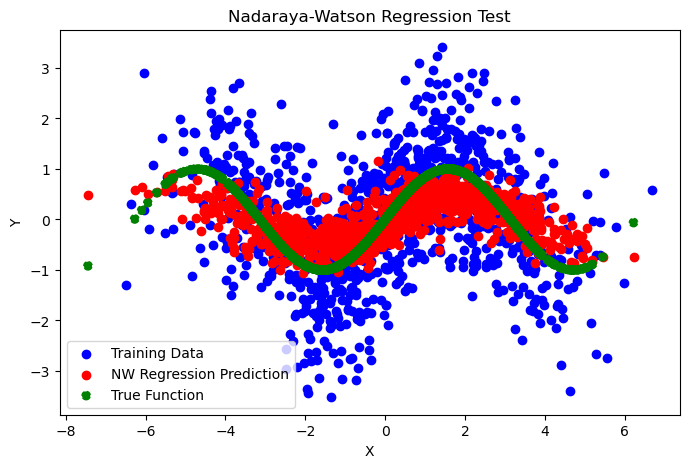

In [1]:
import torch
import torch.nn as nn
from torch.distributions import Uniform
import matplotlib.pyplot as plt
import numpy as np

from causal_cocycle.regression_functionals import NWFunctional
from causal_cocycle.distribution_estimation import ConditionalExpectationRegressor
from causal_cocycle.kernels_new import GaussianKernel

# Create synthetic training data.
# Using a sine function with added noise.
torch.manual_seed(0)
n,D = 1000,10
#Xtrain = torch.linspace(-10, 10, steps=50).unsqueeze(1)  # shape: (50, 1)
Ztrain = Uniform(-1,1).sample((n,D))  # shape: (50, 1)
coeffs = 1/torch.linspace(1,D,D)
coeffs = coeffs/coeffs.sum()
Xtrain = Ztrain @ coeffs * 10
Ytrain = torch.sin(Xtrain) + 1 * torch.randn(Xtrain.size())  # noisy observations
Ytrain = Ytrain.reshape(n,1)

# Create test data.
Ztest = Uniform(-1,1).sample((1000,D))  # shape: (50, 1)
Xtest = Ztest @ coeffs * 10

# Instantiate the kernel and NWFunctional regressor.
kernel = GaussianKernel(lengthscale=torch.ones(D)/D**0.5)  # fixed lengthscale for the kernel
nw_regressor = NWFunctional(kernel, reg=0)

# Optimize hyper
regressor = ConditionalExpectationRegressor(nw_regressor)
#regressor.optimise_old(Ztrain, Ytrain, maxiter=1000, nfold=5, 
#                 learn_rate=1e-1, batch_size=None, 
#norm=2, print_=True)
regressor.optimise(Ztrain, Ytrain, maxiter=1000, nfold=5, learn_rate=1e-1,
                 subsamples=512, norm=2, print_=True)

# Get predictions on the test data.
with torch.no_grad():
    Ypred = regressor.functional(Ytrain, Ztrain, Ztest)

# Convert tensors to numpy arrays for plotting.
Xtrain_np = Xtrain.numpy().squeeze()
Ytrain_np = Ytrain.numpy().squeeze()
Xtest_np = Xtest.numpy().squeeze()
Ypred_np = Ypred.numpy().squeeze()

# Plot the training data, true function, and NW regression prediction.
plt.figure(figsize=(8, 5))
plt.scatter(Xtrain_np, Ytrain_np, color='blue', label='Training Data')
plt.scatter(Xtest_np, Ypred_np, color='red', label='NW Regression Prediction')
plt.scatter(Xtest_np, np.sin(Xtest_np), color='green', linestyle='--', label='True Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Nadaraya-Watson Regression Test')
plt.legend()
plt.show()

In [7]:
log_hypers = torch.log(regressor.functional.kernel.lengthscale[:, None] * 2**torch.linspace(-5, 5, 11)[None])
hyper_grid = [(log_hypers[:, i],) for i in range(11)]
losses = regressor.CVgridsearch(Ztrain, Ytrain, nfold=10, subsample=False, subsamples=1000, 
                     hyper_grid=hyper_grid, norm=2)
print(losses)

Trying hyperparam 0: lengthscale = tensor([0.0036, 0.0079, 0.0088, 0.0166, 0.0171, 0.0202, 0.0221, 0.1953, 0.0548,
        0.0228], grad_fn=<ExpBackward0>)
Trying hyperparam 1: lengthscale = tensor([0.0072, 0.0157, 0.0176, 0.0332, 0.0343, 0.0404, 0.0441, 0.3906, 0.1096,
        0.0457], grad_fn=<ExpBackward0>)
Trying hyperparam 2: lengthscale = tensor([0.0144, 0.0315, 0.0353, 0.0665, 0.0686, 0.0808, 0.0883, 0.7811, 0.2192,
        0.0913], grad_fn=<ExpBackward0>)
Trying hyperparam 3: lengthscale = tensor([0.0289, 0.0630, 0.0706, 0.1329, 0.1372, 0.1617, 0.1766, 1.5623, 0.4384,
        0.1826], grad_fn=<ExpBackward0>)
Trying hyperparam 4: lengthscale = tensor([0.0578, 0.1259, 0.1411, 0.2658, 0.2743, 0.3234, 0.3531, 3.1246, 0.8768,
        0.3653], grad_fn=<ExpBackward0>)
Trying hyperparam 5: lengthscale = tensor([0.1156, 0.2518, 0.2823, 0.5316, 0.5486, 0.6467, 0.7062, 6.2492, 1.7537,
        0.7305], grad_fn=<ExpBackward0>)
Trying hyperparam 6: lengthscale = tensor([ 0.2311,  0.5036,  0.